In [1]:
compression_ratios = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


def round_nearest_ratio(number, ratios=compression_ratios, num_dec_pts=2):
    ratios.sort()
    if number <= ratios[0]:
        return ratios[0]
    if number >= ratios[-1]:
        return ratios[-1]

    for i in range(len(ratios) - 1):
        if ratios[i] < number <= ratios[i + 1]:
            val_1 = round(number - ratios[i], num_dec_pts)
            val_2 = round(ratios[i + 1] - number, num_dec_pts)

            if val_1 == val_2:
                return ratios[i + 1]
            else:
                min_val = round(min(val_1, val_2), num_dec_pts)

                if min_val == val_1:
                    return ratios[i]
                elif min_val == val_2:
                    return ratios[i + 1]


In [2]:
degrees = [x for x in range(5)]

In [3]:
%%time
from data_utils import load_ucr_archive, load_ucr_dataset

data = load_ucr_archive()
#data.drop(data[data["dataset"] == "ACSF1"].index, inplace=True)

#data = load_ucr_dataset(48)
data.head()

CPU times: total: 18.3 s
Wall time: 19.7 s


,dataset,no.,data
0,ACSF1,0,"[(0.0, -0.5847537505592904), (0.00068540095956..."
1,ACSF1,1,"[(0.0, -0.5914343487899152), (0.00068540095956..."
2,ACSF1,2,"[(0.0, -0.5779453493302482), (0.00068540095956..."
3,ACSF1,3,"[(0.0, -0.5889254512922358), (0.00068540095956..."
4,ACSF1,4,"[(0.0, -0.5966331905155597), (0.00068540095956..."


In [4]:
%%time
from spline_utils import generate_knot_vector, generate_knot_counts
from fit import fit_max_spline, fit_max_l1_spline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from spline import evaluate_spline
import pandas as pd

results = []
for index, row in data.iterrows():
    time_series = row['data']
    print(row['dataset'], "no.", row['no.'])
    for degree in degrees:

        counts = generate_knot_counts(num_data_pts=len(time_series), degree=degree, ratios=compression_ratios)
        for count in counts:
            knots = generate_knot_vector(degree, count)

            # calculate results
            max_dist, result = fit_max_spline(time_series, knots, degree)
            fitted_spline = [evaluate_spline(knots, result, degree, x[0]) for x in time_series]
            mse = mean_squared_error(fitted_spline, [x[1] for x in time_series])
            mae = mean_absolute_error(fitted_spline, [x[1] for x in time_series])

            next_row = [row['dataset'], row['no.'], degree, len(time_series), count, count / len(time_series), max_dist,
                        mse, mae]
            results.append(next_row)

ACSF1 no. 0


KeyboardInterrupt: 

In [5]:
df = pd.DataFrame(results,
                  columns=['dataset_name', 'ts_number', 'degree', 'num_data_pts', 'num_knots', 'compression_rate',
                           'max_dist', 'MSE', 'MAE'])
df['compression_rate'] = df['compression_rate'].apply(lambda x: round_nearest_ratio(x))
print(df['compression_rate'].unique())
df

[0.01 0.05 0.1  0.2  0.3  0.4  0.5  0.6  0.7 ]


,dataset_name,ts_number,degree,num_data_pts,num_knots,compression_rate,max_dist,MSE,MAE
0,ACSF1,0,0,1460,14,0.01,1.166359,1.334428,1.155081
1,ACSF1,0,0,1460,73,0.05,1.166359,1.329252,1.152829
2,ACSF1,0,0,1460,146,0.10,1.166359,1.328034,1.152292
3,ACSF1,0,0,1460,292,0.20,1.166324,1.327405,1.152016
4,ACSF1,0,0,1460,438,0.30,1.166324,1.329053,1.152731
5,ACSF1,0,0,1460,584,0.40,1.166324,1.332959,1.154419
6,ACSF1,0,0,1460,730,0.50,1.166324,1.337658,1.156484
7,ACSF1,0,0,1460,876,0.60,1.166324,1.342075,1.158376
8,ACSF1,0,0,1460,1021,0.70,1.165481,1.345277,1.159779
9,ACSF1,0,1,1460,14,0.01,1.166359,1.328681,1.152595


# PLOTS

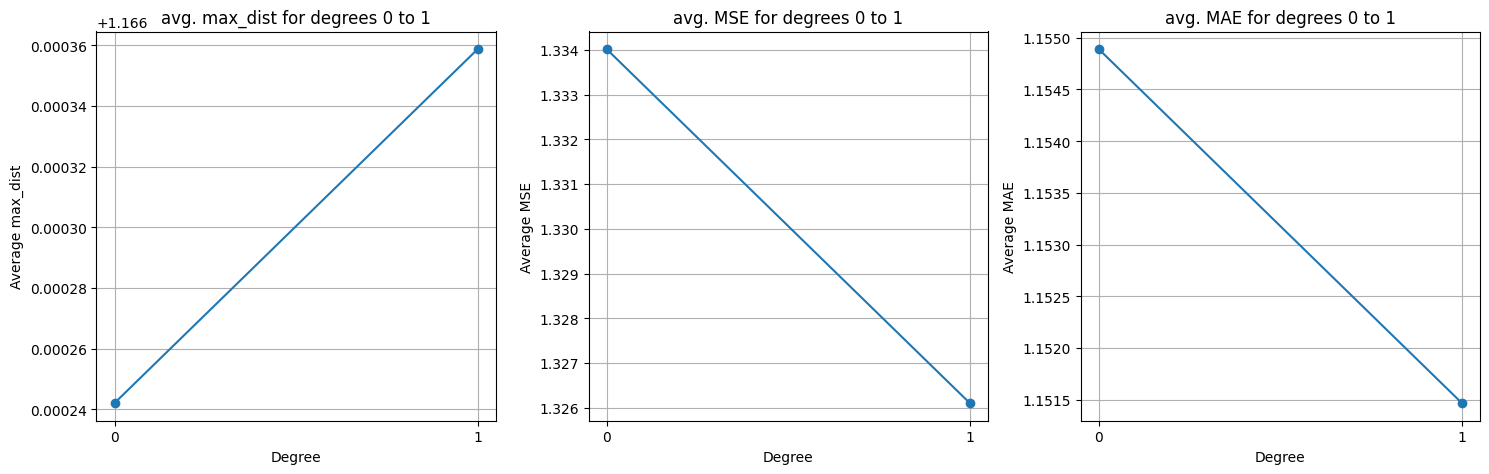

In [9]:
import matplotlib.pyplot as plt

metrics = ['max_dist', 'MSE', 'MAE']
# the same but plotting the graphs next to each other
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    avg_metric_by_degree = df.groupby('degree')[metric].mean()
    axs[i].plot(avg_metric_by_degree.index, avg_metric_by_degree.values, marker='o', linestyle='-')
    axs[i].set_xlabel('Degree')
    axs[i].set_ylabel('Average ' + metric)
    axs[i].set_title('avg. ' + metric + ' for degrees 0 to ' + str(max(df['degree'].unique())))
    axs[i].set_xticks(list(avg_metric_by_degree.index))
    axs[i].grid(True)

plt.tight_layout()
plt.show()

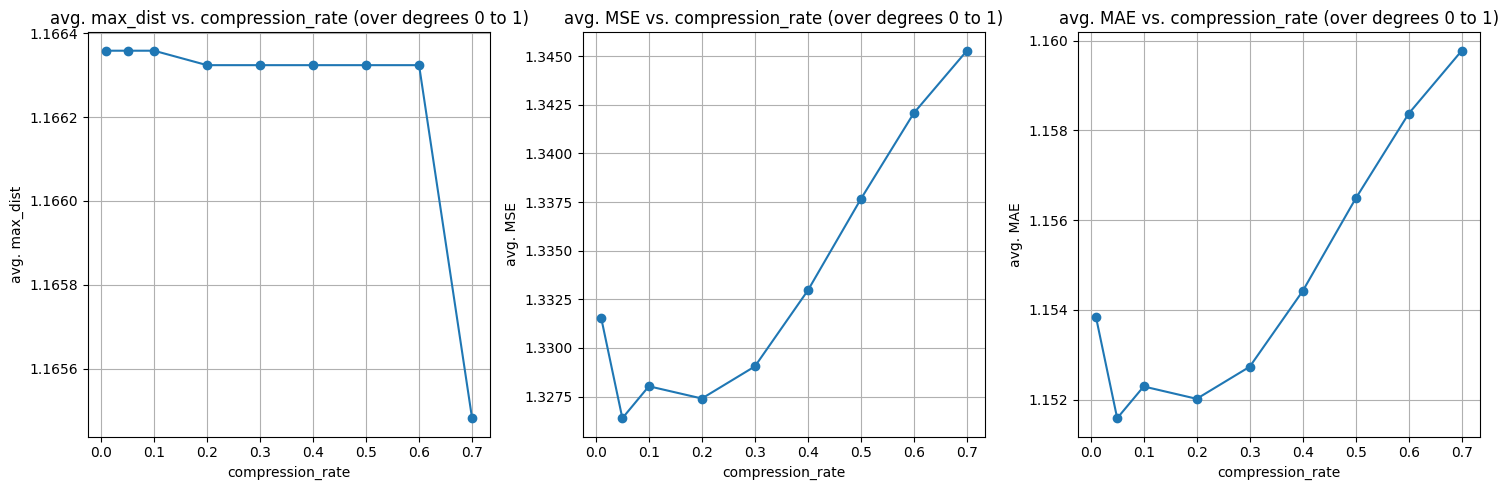

In [10]:
plt.show()
# avg max_dist/mse/mae (accuracy whatever) vs compression rate (avg. over all degrees)
avg_mse_by_compression_rate = df.groupby('compression_rate')['max_dist'].mean()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    avg_mse_by_compression_rate = df.groupby('compression_rate')[metric].mean()
    axs[i].plot(avg_mse_by_compression_rate.index, avg_mse_by_compression_rate.values, marker='o', linestyle='-')
    axs[i].set_xlabel('compression_rate')
    axs[i].set_ylabel('avg. ' + metric)
    axs[i].set_title(
        'avg. ' + metric + ' vs. compression_rate (over degrees 0 to ' + str(max(df['degree'].unique())) + ')')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

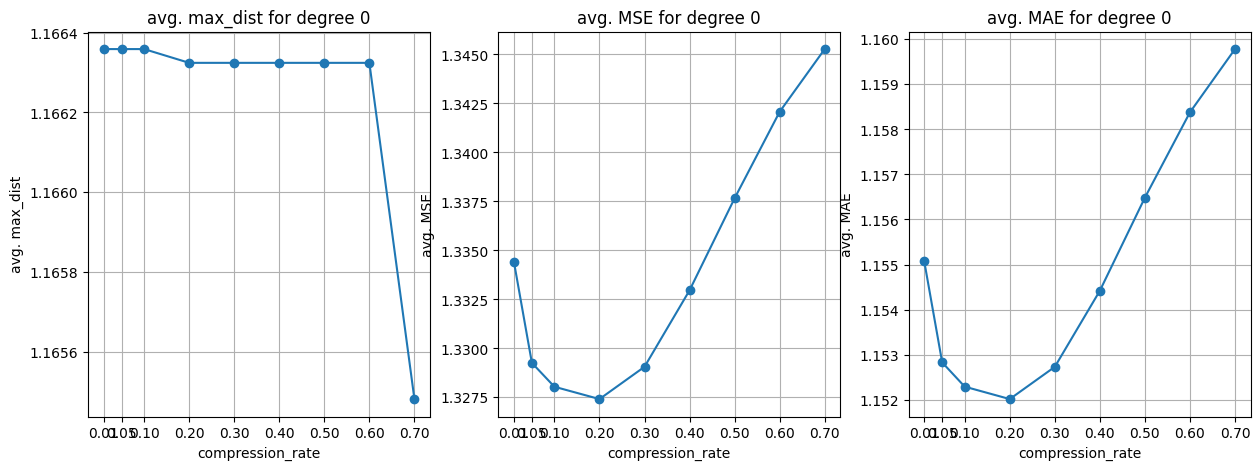

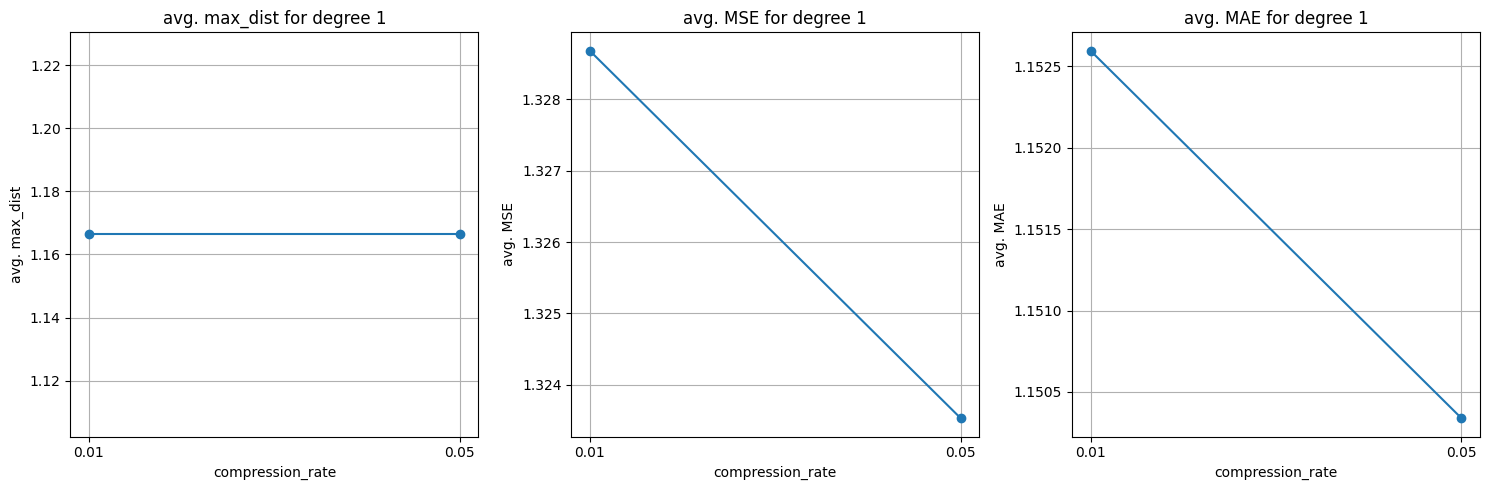

In [8]:
# compression rate vs. avg. accuracy metrics (for each degree)
for degree, group in df.groupby('degree'):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    sub_df = df[df['degree'] == degree]
    for i, metric in enumerate(metrics):
        avg_metric_by_compression = sub_df.groupby('compression_rate')[metric].mean()
        print()
        #x= df.groupby('degree')[metric].mean()
        axs[i].plot(avg_metric_by_compression.index, avg_metric_by_compression.values, marker='o', linestyle='-')
        axs[i].set_xlabel('compression_rate')
        axs[i].set_ylabel('avg. ' + metric)
        axs[i].set_title('avg. ' + metric + ' for degree ' + str(degree))
        axs[i].set_xticks(list(avg_metric_by_compression.index))
        axs[i].grid(True)

plt.tight_layout()
plt.show()